# Siamese Neural Network with Triplet Loss trained on MNIST
## Cameron Trotter
### c.trotter2@ncl.ac.uk

This notebook builds an SNN to determine similarity scores between MNIST digits using a triplet loss function. The use of class prototypes at inference time is also explored. 

This notebook is based heavily on the approach described in [this Coursera course](https://www.coursera.org/learn/siamese-network-triplet-loss-keras/), which in turn is based on the [FaceNet](https://arxiv.org/abs/1503.03832) paper. Any uses of open-source code are linked throughout where utilised. 

For an in-depth guide to understand this code, and the theory behind it, please see LINK.


### Imports

In [25]:
# TF 1.14 gives lots of warnings for deprecations ready for the switch to TF 2.0
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import glob

from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import Callback, CSVLogger, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Input, concatenate
from tensorflow.keras.layers import Layer, BatchNormalization, MaxPooling2D, Concatenate, Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform, he_uniform
from tensorflow.keras.regularizers import l2
# from tensorflow.keras.utils import multi_gpu_model
from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model

from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score
import math
# import pylab as PL
# import matplotlib.pyplot as plt
import matplotlib.pylab as plt
# from pylab import hist
# from pylab import dist
# from pylab import *
import json

from tensorflow.python.client import device_lib
import matplotlib.gridspec as gridspec


## Import the data and reshape for use with the SNN

The data loaded in must be in the same format as `tf.keras.datasets.mnist.load_data()`, that is `(x_train, y_train), (x_test, y_test)`

In [26]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

num_classes = len(np.unique(y_train))

x_train_w = x_train.shape[1] # (60000, 28, 28)
x_train_h = x_train.shape[2]
x_test_w = x_test.shape[1]
x_test_h = x_test.shape[2]

x_train_w_h = x_train_w * x_train_h # 28 * 28 = 784
x_test_w_h = x_test_w * x_test_h

x_train = np.reshape(x_train, (x_train.shape[0], x_train_w_h))/255. # (60000, 784)
x_test = np.reshape(x_test, (x_test.shape[0], x_test_w_h))/255.

### Plotting the triplets

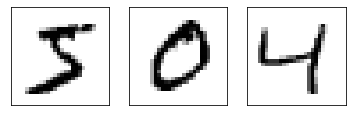

In [27]:
def plot_triplets(examples):
    plt.figure(figsize=(6, 2))
    for i in range(3):
        plt.subplot(1, 3, 1 + i)
        plt.imshow(np.reshape(examples[i], (x_train_w, x_train_h)), cmap='binary')
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
plot_triplets([x_train[0], x_train[1], x_train[2]])

###  Create triplet batches

Random batches are generated by `create_batch`. Semi-hard triplet batches are generated by `create_batch_hard`.

Semi-Hard: dist(A, P) < dist(A, N) < dist(A, P) + margin. Using only easy triplets will lead to no learning. Hard triplets generate high loss and have high impact on training parameters, but may cause any mislabelled data to cause too much of a weight change. 

In [28]:
def create_batch(batch_size=256, split = "train"):
    x_anchors = np.zeros((batch_size, x_train_w_h))
    x_positives = np.zeros((batch_size, x_train_w_h))
    x_negatives = np.zeros((batch_size, x_train_w_h))
    
    if split =="train":
        data = x_train
        data_y = y_train
    else:
        data = x_test
        data_y = y_test
    
    for i in range(0, batch_size):
        # We need to find an anchor, a positive example and a negative example
        random_index = random.randint(0, data.shape[0] - 1)
        x_anchor = data[random_index]
        y = data_y[random_index]
        
        indices_for_pos = np.squeeze(np.where(data_y == y))
        indices_for_neg = np.squeeze(np.where(data_y != y))
        
        x_positive = data[indices_for_pos[random.randint(0, len(indices_for_pos) - 1)]]
        x_negative = data[indices_for_neg[random.randint(0, len(indices_for_neg) - 1)]]
        
        x_anchors[i] = x_anchor
        x_positives[i] = x_positive
        x_negatives[i] = x_negative
        
    return [x_anchors, x_positives, x_negatives]


def create_hard_batch(batch_size, num_hard, split = "train"):
    
    x_anchors = np.zeros((batch_size, x_train_w_h))
    x_positives = np.zeros((batch_size, x_train_w_h))
    x_negatives = np.zeros((batch_size, x_train_w_h))
    
    if split =="train":
        data = x_train
        data_y = y_train
    else:
        data = x_test
        data_y = y_test
    
    # Generate num_hard number of hard examples:
    hard_batches = [] 
    batch_losses = []
    
    rand_batches = []
    
    # Get some random batches
    for i in range(0, batch_size):
        hard_batches.append(create_batch(1, split))
        
        A_emb = embedding_model.predict(hard_batches[i][0])
        P_emb = embedding_model.predict(hard_batches[i][1])
        N_emb = embedding_model.predict(hard_batches[i][2])
        
        # Compute d(A, P) - d(A, N) for each selected batch
        batch_losses.append(np.sum(np.square(A_emb-P_emb),axis=1) - np.sum(np.square(A_emb-N_emb),axis=1))
    
    # Sort batch_loss by distance, highest first, and keep num_hard of them
    hard_batch_selections = [x for _, x in sorted(zip(batch_losses,hard_batches), key=lambda x: x[0])]
    hard_batches = hard_batch_selections[:num_hard]
    
    # Get batch_size - num_hard number of random examples
    num_rand = batch_size - num_hard
    for i in range(0, num_rand):
        rand_batch = create_batch(1, split)
        rand_batches.append(rand_batch)
    
    selections = hard_batches + rand_batches
    
    for i in range(0, len(selections)):
        x_anchors[i] = selections[i][0]
        x_positives[i] = selections[i][1]
        x_negatives[i] = selections[i][2]
        
    return [x_anchors, x_positives, x_negatives]
    
    

### Create the Embedding Model

This model takes in input image and generates some `emb_size`-dimensional embedding for the image, plotted on some latent space.

The untrained model's embedding space is stored for later use when comparing clustering between the untrained and the trained model using PCA, based on [this notebook](https://github.com/AdrianUng/keras-triplet-loss-mnist/blob/master/Triplet_loss_KERAS_semi_hard_from_TF.ipynb).

In [29]:
def create_embedding_model(emb_size):
    embedding_model = tf.keras.models.Sequential([
        Dense(4096,
              activation='relu',
              kernel_regularizer=l2(1e-3),
              kernel_initializer='he_uniform',
              input_shape=(x_train_w_h,)),
        Dense(emb_size,
              activation=None,
              kernel_regularizer=l2(1e-3),
              kernel_initializer='he_uniform')
    ])

    embedding_model.summary()
    
    return embedding_model

### Create the SNN

This model takes a triplet image input, passes them to the embedding model for embedding, then concats them together for the loss function

In [30]:
def create_SNN(embedding_model):

    input_anchor = tf.keras.layers.Input(shape=(x_train_w_h,))
    input_positive = tf.keras.layers.Input(shape=(x_train_w_h,))
    input_negative = tf.keras.layers.Input(shape=(x_train_w_h,))

    embedding_anchor = embedding_model(input_anchor)
    embedding_positive = embedding_model(input_positive)
    embedding_negative = embedding_model(input_negative)

    output = tf.keras.layers.concatenate([embedding_anchor, embedding_positive, 
                                          embedding_negative], axis=1)

    siamese_net = tf.keras.models.Model([input_anchor, input_positive, input_negative], 
                                        output)
    siamese_net.summary()
    
    return siamese_net

### Create the Triplet Loss Function

In [31]:
def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size],y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

### Data Generator

This function creates hard batches for the network to train on. `y` is required by TF but not by our model, so just return a filler to keep TF happy.

In [32]:
def data_generator(batch_size=256, num_hard=50, split="train"):
    while True:
        x = create_hard_batch(batch_size, num_hard, split)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

### Evaluation

Allows for the model's metrics to be visualised and evaluated. Based on [this Medium post](https://medium.com/@crimy/one-shot-learning-siamese-networks-and-triplet-loss-with-keras-2885ed022352) and [this GitHub notebook](https://github.com/asagar60/One-Shot-Learning/blob/master/Omniglot_data/One_shot_implementation.ipynb).

In [33]:
def compute_dist(a,b):
    return np.linalg.norm(a-b)

def compute_probs(network,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all imgs with current embedding network
    embeddings = embedding_model.predict(X)
    
    k = 0
    
    # For each img in the evaluation set
    for i in range(m):
            # Against all other images
            for j in range(i+1,m):
                # compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : \t\t\t{2}\tSAME".format(i,j,probs[k],k, Y[i], Y[j]))
                else:
                    y[k] = 0
                    #print("{3}:{0} vs {1} : {2}\tDIFF".format(i,j,probs[k],k, Y[i], Y[j]))
                k += 1
    return probs, y


def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds,auc

def draw_roc(fpr, tpr,thresholds, auc):
    #find threshold
    targetfpr=1e-3
    _, idx = find_nearest(fpr,targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}\nSensitivity : {2:.1%} @FPR={1:.0e}\nThreshold={3})'.format(auc,targetfpr,recall,abs(threshold) ))
    # show the plot
    plt.show()
    
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
    
def draw_interdist(network, epochs):
    interdist = compute_interdist(network)

    data = []
    for i in range(num_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} epochs'.format(epochs))
    ax.set_ylim([0,3])
    plt.xlabel('Classes')
    plt.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(num_classes))

    plt.show()
    
    
def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (num_classes,num_classes) 
    '''
    res = np.zeros((num_classes,num_classes))
    
    ref_images = np.zeros((num_classes, x_test_w_h))
    
    #generates embeddings for reference images
    for i in range(num_classes):
        ref_images[i,:] = x_test[i]
    
    ref_embeddings = network.predict(ref_images)
    
    for i in range(num_classes):
        for j in range(num_classes):
            print(ref_embeddings[i])
            print(ref_embeddings[j])
            # res[i,j] = plt.hist(ref_embeddings[i],ref_embeddings[j])
            # res[i,j] = (plt.hist(ref_embeddings[i], bins=10),plt.hist(ref_embeddings[j], bins=10))
            res[i,j] = (ref_embeddings[i],ref_embeddings[j])
    return res

def DrawTestImage(network, images, refidx=0):
    '''
    Evaluate some pictures vs some samples in the test set
        image must be of shape(1,w,h,c)
    
    Returns
        scores : result of the similarity scores with the basic images => (N)
    
    '''
    nbimages = images.shape[0]
    
    
    #generates embedings for given images
    image_embedings = network.predict(images)
    
    #generates embedings for reference images
    ref_images = np.zeros((num_classes,x_test_w_h))
    for i in range(num_classes):
        images_at_this_index_are_of_class_i = np.squeeze(np.where(y_test == i))
        ref_images[i,:] = x_test[images_at_this_index_are_of_class_i[refidx]]
        
        
    ref_embedings = network.predict(ref_images)
            
    for i in range(nbimages):
        # Prepare the figure
        fig=plt.figure(figsize=(16,2))
        subplot = fig.add_subplot(1,num_classes+1,1)
        plt.axis("off")
        plotidx = 2
            
        # Draw this image    
        plt.imshow(np.reshape(images[i], (x_train_w, x_train_h)),vmin=0, vmax=1,cmap='Greys')
        subplot.title.set_text("Test image")
            
        for ref in range(num_classes):
            #Compute distance between this images and references
            dist = compute_dist(image_embedings[i,:],ref_embedings[ref,:])
            #Draw
            subplot = fig.add_subplot(1,num_classes+1,plotidx)
            plt.axis("off")
            plt.imshow(np.reshape(ref_images[ref, :], (x_train_w, x_train_h)),vmin=0, vmax=1,cmap='Greys')
            subplot.title.set_text(("Class {0}\n{1:.3e}".format(ref,dist)))
            plotidx += 1

def generate_prototypes(x_data, y_data, embedding_model):
    classes = np.unique(y_data)
    prototypes = {}

    for c in classes:
        #c = classes[0]
        # Find all images of the chosen test class
        locations_of_c = np.where(y_data == c)[0]

        imgs_of_c = x_data[locations_of_c]

        imgs_of_c_embeddings = embedding_model.predict(imgs_of_c)

        # Get the median of the embeddings to generate a prototype for the class (reshaping for PCA)
        prototype_for_c = np.median(imgs_of_c_embeddings, axis = 0).reshape(1, -1)
        # Add it to the prototype dict
        prototypes[c] = prototype_for_c
        
    return prototypes
         
def test_one_shot_prototypes(network, sample_embeddings):
    distances_from_img_to_test_against = []
    # As the img to test against is in index 0, we compare distances between img@0 and all others
    for i in range(1, len(sample_embeddings)):
        distances_from_img_to_test_against.append(compute_dist(sample_embeddings[0], sample_embeddings[i]))
    # As the correct img will be at distances_from_img_to_test_against index 0 (sample_imgs index 1),
    # If the smallest distance in distances_from_img_to_test_against is at index 0, 
    # we know the one shot test got the right answer
    is_min = distances_from_img_to_test_against[0] == min(distances_from_img_to_test_against)
    is_max = distances_from_img_to_test_against[0] == max(distances_from_img_to_test_against)
    return int(is_min and not is_max)
    
def n_way_accuracy_prototypes(n_val, n_way, network):
    num_correct = 0
    
    for val_step in range(n_val):
        num_correct += load_one_shot_test_batch_prototypes(n_way, network)
        
    accuracy = num_correct / n_val * 100
        
    return accuracy

def load_one_shot_test_batch_prototypes(n_way, network):
    
    labels = np.unique(y_test)
    # Reduce the label set down from size n_classes to n_samples 
    labels = np.random.choice(labels, size = n_way, replace = False)

    # Choose a class as the test image
    label = random.choice(labels)
    # Find all images of the chosen test class
    imgs_of_label = np.where(y_test == label)[0]

    # Randomly select a test image of the selected class, return it's index
    img_of_label_idx = random.choice(imgs_of_label)

    # Expand the array at the selected indexes into useable images
    img_of_label = np.expand_dims(x_test[img_of_label_idx],axis=0)
    
    sample_embeddings = []
    # Get the anchor image embedding
    anchor_prototype = network.predict(img_of_label)
    sample_embeddings.append(anchor_prototype)
    
    # Get the prototype embedding for the positive class
    positive_prototype = prototypes[label]
 
    sample_embeddings.append(positive_prototype)
    
    # Get the negative prototype embeddings
    # Remove the selected test class from the list of labels based on it's index 
    label_idx_in_labels = np.where(labels == label)[0]
    other_labels = np.delete(labels, label_idx_in_labels)
    
    # Get the embedding for each of the remaining negatives
    for other_label in other_labels:
        negative_prototype = prototypes[other_label]
        sample_embeddings.append(negative_prototype)
                
    correct = test_one_shot_prototypes(network, sample_embeddings)

    return correct


def visualise_n_way_prototypes(n_samples, network):
    labels = np.unique(y_test)
    # Reduce the label set down from size n_classes to n_samples 
    labels = np.random.choice(labels, size = n_samples, replace = False)

    # Choose a class as the test image
    label = random.choice(labels)
    # Find all images of the chosen test class
    imgs_of_label = np.where(y_test == label)[0]

    # Randomly select a test image of the selected class, return it's index
    img_of_label_idx = random.choice(imgs_of_label)

    # Get another image idx that we know is of the test class for the sample set
    label_sample_img_idx = random.choice(imgs_of_label)

    # Expand the array at the selected indexes into useable images
    img_of_label = np.expand_dims(x_test[img_of_label_idx],axis=0)
    label_sample_img = np.expand_dims(x_test[label_sample_img_idx],axis=0)
    
    # Make the first img in the sample set the chosen test image, the second the other image
    sample_imgs = np.empty((0, x_test_w_h))
    sample_imgs = np.append(sample_imgs, img_of_label, axis=0)
    sample_imgs = np.append(sample_imgs, label_sample_img, axis=0)
    
    sample_embeddings = []
    
    # Get the anchor embedding image
    anchor_prototype = network.predict(img_of_label)
    sample_embeddings.append(anchor_prototype)
    
    # Get the prototype embedding for the positive class
    positive_prototype = prototypes[label]
    sample_embeddings.append(positive_prototype)

    # Get the negative prototype embeddings
    # Remove the selected test class from the list of labels based on it's index 
    label_idx_in_labels = np.where(labels == label)[0]
    other_labels = np.delete(labels, label_idx_in_labels)
    # Get the embedding for each of the remaining negatives
    for other_label in other_labels:
        negative_prototype = prototypes[other_label]
        sample_embeddings.append(negative_prototype)
        
        # Find all images of the other class
        imgs_of_other_label = np.where(y_test == other_label)[0]
        # Randomly select an image of the selected class, return it's index
        another_sample_img_idx = random.choice(imgs_of_other_label)
        # Expand the array at the selected index into useable images
        another_sample_img = np.expand_dims(x_test[another_sample_img_idx],axis=0)
        # Add the image to the support set
        sample_imgs = np.append(sample_imgs, another_sample_img, axis=0)
    
    distances_from_img_to_test_against = []
    
    # As the img to test against is in index 0, we compare distances between img@0 and all others
    for i in range(1, len(sample_embeddings)):
        distances_from_img_to_test_against.append(compute_dist(sample_embeddings[0], sample_embeddings[i]))
        
    # + 1 as distances_from_img_to_test_against doesn't include the test image
    min_index = distances_from_img_to_test_against.index(min(distances_from_img_to_test_against)) + 1
    
    return sample_imgs, min_index

def evaluate(embedding_model, epochs = 0):
    probs,yprob = compute_probs(embedding_model, x_test[:500, :], y_test[:500])
    fpr, tpr, thresholds, auc = compute_metrics(probs,yprob)
    draw_roc(fpr, tpr, thresholds, auc)
    # draw_interdist(embedding_model, epochs)

    for i in range(3):
        DrawTestImage(embedding_model, np.expand_dims(x_train[i],axis=0))

### Model Training Setup

FaceNet, the original triplet batch paper, draws a large random sample of triplets respecting the class distribution then picks N/2 hard and N/2 random samples (N = batch size), along with an `alpha` of 0.2

Logs out to Tensorboard, callback adapted from https://stackoverflow.com/a/52581175.

Saves best model only based on a validation loss. Adapted from https://stackoverflow.com/a/58103272.

Generating embedding model... 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 4096)              3215360   
                                                                 
 dense_5 (Dense)             (None, 10)                40970     
                                                                 
Total params: 3,256,330
Trainable params: 3,256,330
Non-trainable params: 0
_________________________________________________________________

Generating SNN... 

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 784)]        0           []                               
                                                                         

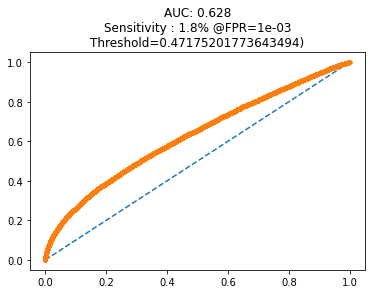

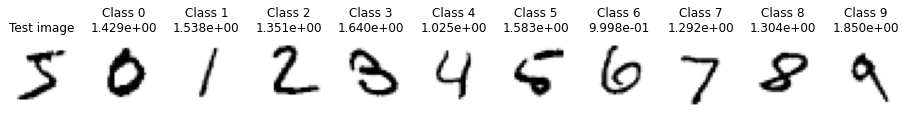

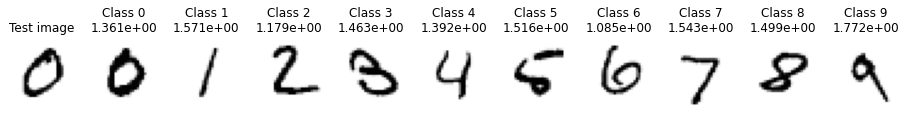

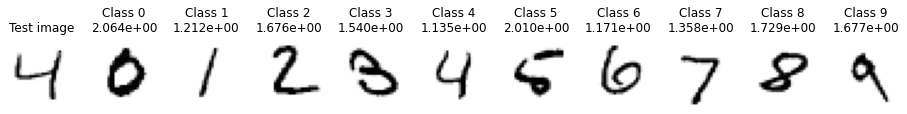

In [34]:
# Hyperparams
batch_size = 64  #256
epochs = 3  #100
steps_per_epoch = int(x_train.shape[0]/batch_size)
val_steps = int(x_test.shape[0]/batch_size)
alpha = 0.2
num_hard = int(batch_size * 0.5) # Number of semi-hard triplet examples in the batch
lr = 0.00006
optimiser = 'Adam'
emb_size = 10

with tf.device("/cpu:0"):
    # Create the embedding model
    print("Generating embedding model... \n")
    embedding_model = create_embedding_model(emb_size)
    
    print("\nGenerating SNN... \n")
    # Create the SNN
    siamese_net = create_SNN(embedding_model)
    # Compile the SNN
    optimiser_obj = Adam(lr = lr)
    siamese_net.compile(loss=triplet_loss, optimizer= optimiser_obj)
    
    # Store visualisations of the embeddings using PCA for display next to "after training" for comparisons
    num_vis = 500 # Take only the first num_vis elements of the test set to visualise
    embeddings_before_train = embedding_model.predict(x_test[:num_vis, :])
    pca = PCA(n_components=2)
    decomposed_embeddings_before = pca.fit_transform(embeddings_before_train)


# Display evaluation the untrained model
print("\nEvaluating the model without training for a baseline...\n")
evaluate(embedding_model)

# Set up logging directory
## Use date-time as logdir name:
#dt = datetime.now().strftime("%Y%m%dT%H%M")
#logdir = os.path.join("PATH/TO/LOGDIR",dt)

## Use a custom non-dt name:
name = "snn-example-run"
logdir = os.path.join(name)

if not os.path.exists(logdir):
    os.mkdir(logdir)

## Callbacks:
# Create the TensorBoard callback
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir = logdir,
    histogram_freq=0,
    batch_size=batch_size,
    write_graph=True,
    write_grads=True, 
    write_images = True, 
    update_freq = 'epoch', 
    profile_batch=0
)

# Training logger
csv_log = os.path.join(logdir, 'training.csv')
csv_logger = CSVLogger(csv_log, separator=',', append=True)

# Only save the best model weights based on the val_loss
checkpoint = ModelCheckpoint(os.path.join(logdir, 'snn_model-{epoch:02d}-{val_loss:.2f}.h5'),
                             monitor='val_loss', verbose=1,
                             save_best_only=True, save_weights_only=True, 
                             mode='auto')

# Save the embedding mode weights based on the main model's val loss
# This is needed to reecreate the emebedding model should we wish to visualise
# the latent space at the saved epoch
class SaveEmbeddingModelWeights(Callback):
    def __init__(self, filepath, monitor='val_loss', verbose=1):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.best = np.Inf
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("SaveEmbeddingModelWeights requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.best:
            filepath = self.filepath.format(epoch=epoch + 1, **logs)
            #if self.verbose == 1:
                #print("Saving embedding model weights at %s" % filepath)
            embedding_model.save_weights(filepath, overwrite = True)
            self.best = current

# Save the embedding model weights if you save a new snn best model based on the model checkpoint above
emb_weight_saver = SaveEmbeddingModelWeights(os.path.join(logdir, 'emb_model-{epoch:02d}.h5'))


callbacks = [tensorboard, csv_logger, checkpoint, emb_weight_saver]


# Save model configs to JSON
model_json = siamese_net.to_json()
with open(os.path.join(logdir, "siamese_config.json"), "w") as json_file:
    json_file.write(model_json)
    json_file.close()
    
model_json = embedding_model.to_json()
with open(os.path.join(logdir, "embedding_config.json"), "w") as json_file:
    json_file.write(model_json)
    json_file.close()
    

hyperparams = {'batch_size' : batch_size,
              'epochs' : epochs, 
               'steps_per_epoch' : steps_per_epoch, 
               'val_steps' : val_steps, 
               'alpha' : alpha, 
               'num_hard' : num_hard, 
               'optimiser' : optimiser,
               'lr' : lr,
               'emb_size' : emb_size
              }


with open(os.path.join(logdir, "hyperparams.json"), "w") as json_file:
    json.dump(hyperparams, json_file)
    
# Set the model to TB
tensorboard.set_model(siamese_net)


def delete_older_model_files(filepath):
    
    model_dir = filepath.split("emb_model")[0]
    
    # Get model files
    model_files = os.listdir(model_dir)

    # Get only the emb_model files
    emb_model_files = [file for file in model_files if "emb_model" in file]
    # Get the epoch nums of the emb_model_files
    emb_model_files_epoch_nums = [int(file.split("-")[1].split(".h5")[0]) for file in emb_model_files]

    # Find all the snn model files
    snn_model_files = [file for file in model_files if "snn_model" in file]

    # Sort, get highest epoch num
    emb_model_files_epoch_nums.sort()
    highest_epoch_num = str(emb_model_files_epoch_nums[-1]).zfill(2)

    # Filter the emb_model and snn_model file lists to remove the highest epoch number ones
    emb_model_files_without_highest = [file for file in emb_model_files if highest_epoch_num not in file]
    snn_model_files_without_highest = [file for file in snn_model_files if ("-" + highest_epoch_num + "-") not in file]

    # Delete the non-highest model files from the subdir
    if len(emb_model_files_without_highest) != 0:
        print("Deleting previous best model file")
    for model_file_list in [emb_model_files_without_highest, snn_model_files_without_highest]:
        for file in model_file_list:
            os.remove(os.path.join(model_dir, file))

### Show example batches

Based on code found [here](https://zhangruochi.com/Create-a-Siamese-Network-with-Triplet-Loss-in-Keras/2020/08/11/).

Example triplet batch:


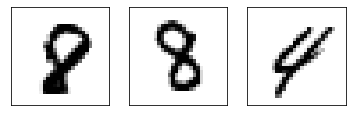

Example semi-hard triplet batch:


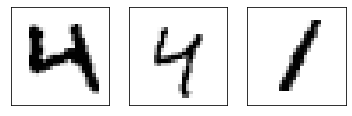

In [35]:
# Display sample batches. This has to be performed after the embedding model is created
# as create_batch_hard utilises the model to see which batches are actually hard.

examples = create_batch(1)
print("Example triplet batch:")
plot_triplets(examples)

print("Example semi-hard triplet batch:")
ex_hard = create_hard_batch(1, 1, split="train")
plot_triplets(ex_hard)

### Training

Using `.fit(workers = 0)` fixes the error when using hard batches where TF can't predict on the embedding network whilst fitting the siamese network (see: https://github.com/keras-team/keras/issues/5511#issuecomment-427666222).

In [36]:
def get_num_gpus():
    local_device_protos = device_lib.list_local_devices()
    return len([x.name for x in local_device_protos if x.device_type == 'GPU'])

## Training:
#print("Logging out to Tensorboard at:", logdir)
print("Starting training process!")
print("-------------------------------------")

# Make the model work over the two GPUs we have
# num_gpus = get_num_gpus()
# parallel_snn = multi_gpu_model(siamese_net, gpus = num_gpus)
num_gpus = 1
parallel_snn = siamese_net
batch_per_gpu = int(batch_size / num_gpus)

parallel_snn.compile(loss=triplet_loss, optimizer= optimiser_obj)

siamese_history = parallel_snn.fit(
    data_generator(batch_per_gpu, num_hard),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks, 
    workers = 0, 
    validation_data = data_generator(batch_per_gpu, num_hard, split="test"), 
    validation_steps = val_steps)

print("-------------------------------------")
print("Training complete.")

Starting training process!
-------------------------------------
Epoch 1/3
568/937 [=================>............] - ETA: 32:00 - loss: 5.5727  

KeyboardInterrupt: 

### Evaluate the trained network

Load the best performing models. We need to load the weights and configs seperately rather than using model.load() as our custom loss function relies on the embedding length. As such, it is easier to load the weights and config seperately and build a model based on them.

In [ ]:
def json_to_dict(json_src):
    with open(json_src, 'r') as j:
        return json.loads(j.read())

In [ ]:
## Load in best trained SNN and emb model

# The best performing model weights has the higher epoch number due to only saving the best weights
highest_epoch = 0
dir_list = os.listdir(logdir)

for file in dir_list:
    if file.endswith(".h5"):
        epoch_num = int(file.split("-")[1].split(".h5")[0])
        if epoch_num > highest_epoch:
            highest_epoch = epoch_num

# Find the embedding and SNN weights src for the highest_epoch (best) model
for file in dir_list:
    # Zfill ensure a leading 0 on number < 10
    if ("-" + str(highest_epoch).zfill(2)) in file:
        if file.startswith("emb"):
            embedding_weights_src = os.path.join(logdir, file)
        elif file.startswith("snn"):
            snn_weights_src = os.path.join(logdir, file)

hyperparams = os.path.join(logdir, "hyperparams.json")
snn_config = os.path.join(logdir, "siamese_config.json")
emb_config = os.path.join(logdir, "embedding_config.json")

snn_config = json_to_dict(snn_config)
emb_config = json_to_dict(emb_config)

# json.dumps to make the dict a string, as required by model_from_json
loaded_snn_model = model_from_json(json.dumps(snn_config))
loaded_snn_model.load_weights(snn_weights_src)

loaded_emb_model = model_from_json(json.dumps(emb_config))
loaded_emb_model.load_weights(embedding_weights_src)


# Store visualisations of the embeddings using PCA for display next to "after training" for comparisons
embeddings_after_train = loaded_emb_model.predict(x_test[:num_vis, :])
pca = PCA(n_components=2)
decomposed_embeddings_after = pca.fit_transform(embeddings_after_train)
evaluate(loaded_emb_model, highest_epoch)

### Comparisons of the embeddings in the latent space

Based on [this notebook](https://github.com/AdrianUng/keras-triplet-loss-mnist/blob/master/Triplet_loss_KERAS_semi_hard_from_TF.ipynb).

In [ ]:
step = 1 # Step = 1, take every element

dict_embeddings = {}
dict_gray = {}
test_class_labels = np.unique(np.array(y_test))

decomposed_embeddings_after = pca.fit_transform(embeddings_after_train)

fig = plt.figure(figsize=(16, 8))
for label in test_class_labels:
    
    y_test_labels = y_test[:num_vis]
    
    decomposed_embeddings_class_before = decomposed_embeddings_before[y_test_labels == label]
    decomposed_embeddings_class_after = decomposed_embeddings_after[y_test_labels == label]
    
    plt.subplot(1,2,1)
    plt.scatter(decomposed_embeddings_class_before[::step, 1], decomposed_embeddings_class_before[::step, 0], label=str(label))
    plt.title('Embedding Locations Before Training')
    plt.legend()

    plt.subplot(1,2,2)
    plt.scatter(decomposed_embeddings_class_after[::step, 1], decomposed_embeddings_class_after[::step, 0], label=str(label))
    plt.title('Embedding Locations After %d Training Epochs' % epochs)
    plt.legend()

plt.show()

### Determine n_way_accuracy

In [ ]:
prototypes = generate_prototypes(x_test, y_test, loaded_emb_model)
n_way_accuracy_prototypes(val_steps, num_classes, loaded_emb_model)


### Visualise support set inference

Based on code found [here](https://github.com/asagar60/One-Shot-Learning/blob/master/Omniglot_data/One_shot_implementation.ipynb).

In [ ]:
n_samples = 10
sample_imgs, min_index = visualise_n_way_prototypes(n_samples, loaded_emb_model)

img_matrix = []
for index in range(1, len(sample_imgs)):
    img_matrix.append(np.reshape(sample_imgs[index], (x_train_w, x_train_h)))

img_matrix = np.asarray(img_matrix)
img_matrix = np.vstack(img_matrix)

f, ax = plt.subplots(1, 3, figsize = (10, 12))
f.tight_layout()
ax[0].imshow(np.reshape(sample_imgs[0], (x_train_w, x_train_h)),vmin=0, vmax=1,cmap='Greys')
ax[0].set_title("Test Image")
ax[1].imshow(img_matrix ,vmin=0, vmax=1,cmap='Greys')
ax[1].set_title("Support Set (Img of same class shown first)")
ax[2].imshow(np.reshape(sample_imgs[min_index], (x_train_w, x_train_h)),vmin=0, vmax=1,cmap='Greys')
ax[2].set_title("Image most similar to Test Image in Support Set")